<a href="https://colab.research.google.com/github/rescobarcorrea/CloudSensedSGD/blob/main/CloudComputedFSGDv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# *Yellow Submarine: A cloud-computed Simulation of Groundwater Discharge of the Coastal Catchments of Australia**

## Summary

This code is capable of simulating groundwater discharge of selected coastal catchmets in the Australian continent. The code builds on a lumped model ([Hajati et al., 2019](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2018WR024248)) and uses the capacity of Google Earth Engine and Google Colabs to adquire and  processes massive satellite inputs and run the model with absurd eficiency. 

## How to use

Execute each cell with CRTL+Enter or by clickn in the play simbol at the top left corner of each cell.

##1. Install stuff

In [ ]:
!pip install -U -q earthengine-api
!pip install -U -q folium
!pip install -U -q git+https://github.com/mccarthyryanc/folium_gee.git

!pip install geopandas
#!pip install descartes 
!pip install geemap

     |████████████████████████████████| 102kB 2.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.11.0 which is incompatible.
     |████████████████████████████████| 972kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 18.0MB/s 
     |████████████████████████████████| 14.7MB 291kB/s 
     |████████████████████████████████| 378kB 1.9MB/s 
     |████████████████████████████████| 5.9MB 7.2MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 225kB 36.9MB/s 
     |████████████████████████████████| 4.7MB 45.2MB/s 
     |████████████████████████████████| 1.1MB 44.9MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 5.1MB 42.8MB/s 
     |████████████████████████████████| 921kB 44.5MB/s 
     |████████████████████████████████| 184kB 46.5MB/s 
     |████████████████████████████████| 122kB 43.2MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-non

## 2. Authenticate

In [ ]:
# Click here to authenticate
!earthengine authenticate 

Instructions for updating:
non-resource variables are not supported in the long term
Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=2OKbDkEcY_5J9qZqGklNu4HuE8D4jBjQxqjW83bnOQ0&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/3QGUl4uoOddE4phl-xdTirbJEayiHZi5cZIX2hVC5GumknQVld-VXj4

Successfully saved authorization token.


## 3. Start it up!

In [ ]:
import ee
import folium
import foliumgee
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.distance import geodesic
from scipy.spatial.distance import cdist
from geopy.distance import distance as geodist # avoid naming confusion
import subprocess
import os
import numpy as np
from pprint import pprint
from google.colab import files
#from datetime import datetime
from datetime import datetime
from datetime import timedelta
from datetime import date
import time
from dateutil.parser import parse
try:
        import geemap
except ImportError:
        print('geemap package not installed. Installing ...')
        subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
        import google.colab
        import geemap.eefolium as emap
except:
        import geemap as emap


from google.colab import drive
drive.mount('/content/drive')  

try:
  ee.Initialize()
  print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
  print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Earth Engine has initialized successfully!


In [ ]:
#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

## 4. Get aquifer inputs (requires tu run 1, 2 and 3)

### *4.1 Aquifer inputs that I need to upload from my PC*

*## Potential improvement: Select on click SGD basins or select default basins*


### *4.2 Aquifer inputs from global satellite datasets*

In [ ]:
# Import the selected coastal cathments from Hydrosheds Basins Lv. 12.
SGDbasins = ee.FeatureCollection('users/rescobarcorrea/CoCatch_aus')
resolution=50 # resolution in meters
#Saving paths
input_folder='drive/My Drive/FSGD-aus/model_input/'
output_folder='drive/My Drive/FSGD-aus/model_output/'

# Import necessary datasets

AWC=ee.Image("CSIRO/SLGA/AWC")#Available Water Capacity
BDW=ee.Image("CSIRO/SLGA/BDW")#Bulk density
CLY=ee.Image("CSIRO/SLGA/CLY")#Clay
DER=ee.Image("CSIRO/SLGA/DER")#Depth of Regolith
DES=ee.Image("CSIRO/SLGA/DES")# Depth of soil profile
ECE=ee.Image("CSIRO/SLGA/ECE")#Efective cation
NTO=ee.Image("CSIRO/SLGA/NTO")#Total Nitrogen
pHc=ee.Image("CSIRO/SLGA/pHc")#pH
PTO=ee.Image("CSIRO/SLGA/PTO")#Total phosphorus
SLT=ee.Image("CSIRO/SLGA/SLT")#Silt
SND=ee.Image("CSIRO/SLGA/SND")#Sand
SOC=ee.Image("CSIRO/SLGA/SOC")#SOC
LogK=ee.Image('users/rescobarcorrea/LogK_aus')# Log of superficial aquifer Permehability - band B1
porosity=ee.Image('users/rescobarcorrea/Porosity_aus') # Aquifer porosity - band B1-1

### Elevation 5m
DEM=ee.Image("AU/GA/DEM_1SEC/v10/DEM-H").select('elevation')
#DEM_stats = DEM.reduceRegions(SGDbasins, 'mean', resolution)

# Concatenate everything
composite = ee.Image.cat([DEM, AWC,BDW,CLY,DER,DES,ECE,NTO,PTO,SLT,SND,SOC,pHc,LogK,porosity])


In [ ]:
# Extract mean value of soil properties for each SGD basin
dist_stats = composite.reduceRegions(SGDbasins, 'mean', resolution)
# get dictionary
dist_stats = dist_stats.getInfo()

# Convert dictionary into pandas dataframe
soilproperties = pd.DataFrame()
for dist in dist_stats['features']:
    df = pd.DataFrame([dist['properties']], columns=dist['properties'].keys())
    soilproperties = pd.concat([soilproperties, df], axis=0)
#Save
soilproperties.to_csv(input_folder+'soilproperties.csv')
# display dataframe
soilproperties

,AWC_000_005_05,AWC_000_005_95,AWC_000_005_EV,AWC_005_015_05,AWC_005_015_95,AWC_005_015_EV,AWC_015_030_05,AWC_015_030_95,AWC_015_030_EV,AWC_030_060_05,AWC_030_060_95,AWC_030_060_EV,AWC_060_100_05,AWC_060_100_95,AWC_060_100_EV,AWC_100_200_05,AWC_100_200_95,AWC_100_200_EV,BDW_000_005_05,BDW_000_005_95,BDW_000_005_EV,BDW_005_015_05,BDW_005_015_95,BDW_005_015_EV,BDW_015_030_05,BDW_015_030_95,BDW_015_030_EV,BDW_030_060_05,BDW_030_060_95,BDW_030_060_EV,BDW_060_100_05,BDW_060_100_95,BDW_060_100_EV,BDW_100_200_05,BDW_100_200_95,BDW_100_200_EV,CLY_000_005_05,CLY_000_005_95,CLY_000_005_EV,CLY_005_015_05,...,SOC_005_015_95,SOC_005_015_EV,SOC_015_030_05,SOC_015_030_95,SOC_015_030_EV,SOC_030_060_05,SOC_030_060_95,SOC_030_060_EV,SOC_060_100_05,SOC_060_100_95,SOC_060_100_EV,SOC_100_200_05,SOC_100_200_95,SOC_100_200_EV,SORT,SUB_AREA,UP_AREA,Xcentroid,Ycentroid,b1,b1_1,elevation,pHc_000_005_05,pHc_000_005_95,pHc_000_005_EV,pHc_005_015_05,pHc_005_015_95,pHc_005_015_EV,pHc_015_030_05,pHc_015_030_95,pHc_015_030_EV,pHc_030_060_05,pHc_030_060_95,pHc_030_060_EV,pHc_060_100_05,pHc_060_100_95,pHc_060_100_EV,pHc_100_200_05,pHc_100_200_95,pHc_100_200_EV
0,5.413679,20.647914,13.030797,6.025190,20.261773,13.143482,6.665917,19.963721,13.314819,6.250052,19.880664,13.065358,5.598845,19.879946,12.739395,3.027344,20.955512,11.991428,0.992476,1.700070,1.400756,1.063256,1.730688,1.412799,1.111830,1.796858,1.435527,1.172981,1.884484,1.411618,1.194649,2.123711,1.420805,1.246592,2.225554,1.456047,0.792283,21.415392,5.154186,0.658069,...,11.475358,2.831902,0.432984,6.388045,1.605744,0.212040,4.535309,0.927366,0.127932,3.649506,0.589207,0.080502,2.562896,0.417996,21558,1.990,2.000,116.803310,-35.023311,-1.015323,0.224382,23.665728,3.924639,5.596964,4.614765,3.867917,5.510521,4.612421,3.766228,5.778659,4.663062,3.861462,6.186075,4.796985,3.948474,6.339504,4.943775,3.746057,6.094228,4.800022
0,6.478893,21.729927,14.104410,7.091464,21.345234,14.218349,7.726846,21.048973,14.387909,7.343812,20.991382,14.167597,6.740755,21.028867,13.884811,4.169289,22.067449,13.118369,1.196539,1.593624,1.395081,1.242479,1.609950,1.426215,1.271420,1.650385,1.460903,1.331863,1.662385,1.497124,1.353315,1.701637,1.527476,1.409113,1.737509,1.573311,4.835511,32.947961,18.891736,4.941929,...,6.016736,1.630368,0.295424,4.384658,1.130164,0.190180,3.892680,0.846883,0.130574,3.402259,0.631203,0.104916,3.240062,0.530221,37548,1.990,2.000,148.299113,-20.121031,-6.857519,0.077340,15.066567,4.520150,5.994686,5.212778,4.513274,6.217873,5.259542,4.469145,6.567436,5.364704,4.506311,6.652525,5.474146,4.944130,7.395994,5.961426,5.097666,7.949357,6.146074
0,6.873967,22.125927,14.499947,7.512844,21.775680,14.644262,8.201662,21.525264,14.863463,7.931579,21.567861,14.749720,7.454112,21.743654,14.598883,5.171121,23.041977,14.106549,1.231539,2.388033,1.459798,1.290716,2.405333,1.496454,1.318837,2.401436,1.534498,1.354493,2.402355,1.550122,1.365695,2.318089,1.583031,1.405154,2.142949,1.586364,3.434914,18.478965,9.886499,3.074058,...,4.032140,1.075282,0.201801,2.998329,0.754102,0.101849,2.115244,0.428548,0.065095,1.705554,0.303727,0.044491,1.386798,0.228678,27844,2.500,2.500,126.266863,-14.238197,-5.117934,0.116815,19.038901,4.556547,6.016082,5.260105,4.505326,6.065262,5.259137,4.432062,6.311522,5.340692,4.507328,6.530999,5.479944,4.669896,6.816901,5.700408,4.773120,7.063614,5.867595
0,5.966166,21.164118,13.565142,6.603828,20.803455,13.703641,7.264873,20.526863,13.895868,6.953126,20.544267,13.748696,6.424765,20.660799,13.542782,4.076174,21.942690,13.009432,1.242287,1.624569,1.433428,1.293232,1.645251,1.469241,1.322268,1.692755,1.507512,1.353646,1.673192,1.513419,1.370234,1.708316,1.539275,1.411206,1.725715,1.568461,2.849247,30.117703,16.483475,2.837230,...,5.004131,1.383114,0.248883,3.603879,0.957201,0.112142,2.377719,0.456542,0.071245,1.889656,0.322679,0.050070,1.586396,0.243353,36021,2.480,2.500,143.739098,-14.349466,-0.617378,0.354305,20.741074,4.193949,5.563291,4.858696,4.148958,5.630640,4.866195,4.101530,5.93629

In [ ]:
#  Download
files.download(input_folder+'soilproperties.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



### *4.3 Do empirical equations to estimate aquifer properties*
de Boer and Hodnet-Tomasella

#### *4.3.0 Estimate Basin Area in (m2)*

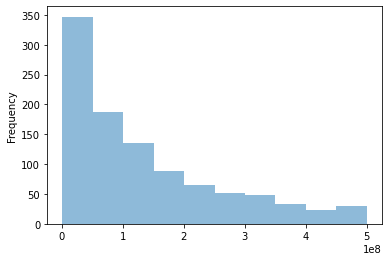

In [ ]:
# This function computes the feature's geometry area and adds it as a property.
def addArea(feature):
  return feature.set({'areasqm': feature.geometry().area()})
# Map the area getting function over the FeatureCollection.
areaAdded = SGDbasins.map(addArea)
#pprint(areaAdded.first().getInfo())

#areaAdded.getInfo()['features'][2]['properties']['areasqm']
areas=[]
for feature in areaAdded.getInfo()['features']:
  #print(feature['properties']['areasqm'])
  areas.append(feature['properties']['areasqm'])
areaspd=pd.DataFrame()
areaspd['area']=areas
plt.figure()
areaspd['area'].plot.hist(alpha=0.5)

#### *4.3.1 Estimate parameter L*
Here I estimate the parameter L as the distance from the centroid of each basin to the coastline, aprox. to half of the distance of the length of the aquifer
see: [(Kraijenhoff, 500bc)](https://library.wur.nl/WebQuery/wurpubs/fulltext/422032) 

In [ ]:
# Import australian continental SHP
australia = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017').filter(ee.Filter.eq('country_na',"Australia"))
# get coordinates of the vertex
coords_aus=np.array(australia.getInfo()['features'][0]['geometry']['coordinates'])



In [ ]:
# Get the centroids of each basin

# This function creates a new feature from the centroid of the geometry.
def getCentroid(feature):
  # Keep this list of properties.
  keepProperties = ['id', 'PFAF_ID']
  # Get the centroid of the feature's geometry.
  centroid = feature.geometry().centroid()
  # Return a new Feature, copying properties from the old Feature.
  return ee.Feature(centroid).copyProperties(feature, keepProperties)


# Map the centroid getting function over the features.
centroids = SGDbasins.map(getCentroid)
#centroids.getInfo()['features'][1]['geometry']['coordinates']
#australia.getInfo()['features'][0]['geometry']['coordinates'][0][0][0]

In [ ]:
# Method 1, very slow iterates through eveyr centroid and every vertex of Aus SHP

# transform coordinates australia to a vector
list_coords_aus=[]
#coords_aus[a][b][c][x,y]
for a in coords_aus:
  #[b][c][d]
   for b in a:
     #[c][d]
     for c in b:
       #[x,y]
       list_coords_aus.append(c)

paramL=[]
counter=0
total=len (centroids.getInfo()['features'])
for centroid in centroids.getInfo()['features']:
  p1=(centroid['geometry']['coordinates'][1],centroid['geometry']['coordinates'][0]) #lat,lon
  counter+=1
  print (counter,' of ',total)
  dist=[]
  for vertex in list_coords_aus:
    p2=(vertex[1],vertex[0])
    d=geodesic(p1,p2).meters
    dist.append(d)
  minDist=np.min(dist)
  paramL.append(minDist)
  #print (minDist)


In [ ]:
# Method 2, very slow iterates only through every centroid
# .map better
paramL=[]
counter=0
total=len (centroids.getInfo()['features'])
p1=[]
for centroid in centroids.getInfo()['features']:
  p=(centroid['geometry']['coordinates'][1],centroid['geometry']['coordinates'][0]) #lat,lon
  p1.append(p)
  counter+=1
  print (counter,' of ',total)
  dist=[]
  sc_dist = cdist(p1,c_aus, lambda u, v: geodist(u, v).meters)
  p1=[]
  minDist=np.min(sc_dist)
  paramL.append(minDist)
  print (minDist)


In [ ]:
#Menthod 3 similar to last one This one is working, but not veery quick

# estimating distances eficiently (method of Lambda and apply... in progress)
c_aus=[]
stuff=()
#coords_aus[a][b][c][x,y]
for a in coords_aus:
  #[b][c][d]
   for b in a:
     #[c][d]
     for c in b:
       #[x,y]
       stuff=(c[1],c[0])
       c_aus.append(stuff)
       
       #print(c)
c_centroids=[]
stuff=()
for centroid in centroids.getInfo()['features']: # instead of getInfo, try .evaluate
  stuff=(centroid['geometry']['coordinates'][1],centroid['geometry']['coordinates'][0])
  c_centroids.append(stuff)

# this one owkrs
sc_dist = cdist(c_centroids,c_aus, lambda u, v: geodist(u, v).meters)

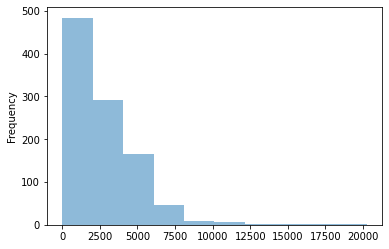

In [ ]:
# Method 4 Read it from shapefile

# Import australian continental SHP

L=soilproperties['Ldist']
plt.figure()
L.plot.hist(alpha=0.5)

#### *4.3.2 Pedotransfer equations*
Here I estimate the parameter L as the distance from the centroid of each basin to the coastline, aprox. to half of the distance of the length of the aquifer
see: [(Kraijenhoff, 500bc)](https://library.wur.nl/WebQuery/wurpubs/fulltext/422032) 

In [ ]:
# Top soil dephs
# 0-5cm
ts1='000_005'
# 5-15cm
ts2='005_015'
# 15-30cm
ts3='015_030'
# Sub soil dephs
# 30-60cm
ss1='030_060'
# 60-100m
ss2='060_100'

0.43504430300180674 0.0358307525142252 0.5652446896242471 0.37386377984645053


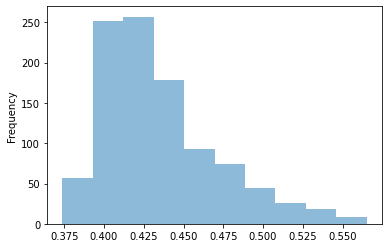

In [ ]:
#@title Top soil max saturated water content (%)
#De Boer 2016
#0.81799 + 0.00099 * CLY – 0.3142 * BDW + 0.00018 * ECE + 0.00451 * PH – 0.000005 *SND * CLY 
# 0-5cm
T1_WCsat_average1=((0.00099*soilproperties['CLY_'+ts1+'_EV'])
+ 0.81799 +(-0.3142*soilproperties['BDW_'+ts1+'_EV'])
+(0.00018*soilproperties['ECE_'+ts1+'_EV'])
+(0.00451*(soilproperties['pHc_'+ts1+'_EV']+.8))
+(-0.000005*soilproperties['SND_'+ts1+'_EV']*soilproperties['CLY_'+ts1+'_EV']))  

# 5-15cm

T1_WCsat_average2=((0.00099*soilproperties['CLY_'+ts2+'_EV'])
+ 0.81799 +(-0.3142*soilproperties['BDW_'+ts2+'_EV'])
+(0.00018*soilproperties['ECE_'+ts2+'_EV'])
+(0.00451*(soilproperties['pHc_'+ts2+'_EV']+.8))
+(-0.000005*soilproperties['SND_'+ts2+'_EV']*soilproperties['CLY_'+ts2+'_EV']))
# 5-15cm


T1_WCsat_average3=((0.00099*soilproperties['CLY_'+ts3+'_EV'])
+ 0.81799 +(-0.3142*soilproperties['BDW_'+ts3+'_EV'])
+(0.00018*soilproperties['ECE_'+ts3+'_EV'])
+(0.00451*(soilproperties['pHc_'+ts3+'_EV']+.8))
+(-0.000005*soilproperties['SND_'+ts3+'_EV']*soilproperties['CLY_'+ts3+'_EV']))

# max
t1wc=pd.DataFrame()
t1wc['1']=T1_WCsat_average1
t1wc['2']=T1_WCsat_average2
t1wc['3']=T1_WCsat_average3
T1_WCsat_max=t1wc[['1','2','3']].max(axis=1)

T1_WCsat_max
print(np.mean(T1_WCsat_max),np.std(T1_WCsat_max),np.max(T1_WCsat_max),np.min(T1_WCsat_max))
plt.figure()
T1_WCsat_max.plot.hist(alpha=0.5)

0.48927024171373557 0.0693310496318475 0.7000445195072006 0.2715589692872237


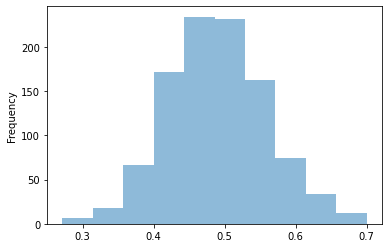

In [ ]:
#@title Soil depth (Horizons a+b)/2 (m)
# Soil depth (Horizons a+b)
#dIVIDE BY 2 assuming horizons A+B equal
T1_depth_avg=soilproperties['DES_000_200_EV']/2

print(np.mean(T1_depth_avg),np.std(T1_depth_avg),np.max(T1_depth_avg),np.min(T1_depth_avg))

plt.figure()
T1_depth_avg.plot.hist(alpha=0.5)

20.565534312584948 19.190108196845884 111.8705131394709 2.3683401668308717


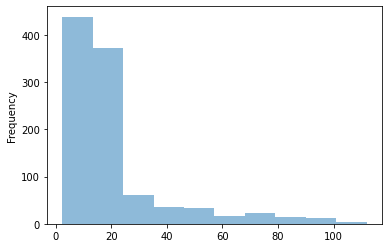

In [ ]:
#@title T3_k_average (mm/d)
#De Boer 2016
#10**(0.4220+(0.26122*pH)+(0.44565*T/S)+(-0.02329*Cl)+(-0.01265*Si)+(-0.01038*CEC))
# 30-60cm

S2_k_average1=10**(0.4220+(0.26122*(soilproperties['pHc_'+ss1+'_EV']+.8))+
                   0.44565+(-0.02329*soilproperties['SLT_'+ss1+'_EV'])+
                   (-0.01265*soilproperties['SLT_'+ss1+'_EV'])+
                   (-0.01038*soilproperties['ECE_'+ss1+'_EV']))
# 60-100cm

S2_k_average2=10**(0.4220+(0.26122*(soilproperties['pHc_'+ss2+'_EV']+.8))+
                   0.44565+(-0.02329*soilproperties['SLT_'+ss2+'_EV'])+
                   (-0.01265*soilproperties['SLT_'+ss2+'_EV'])+
                   (-0.01038*soilproperties['ECE_'+ss2+'_EV']))

# average
T3_k_avg=(S2_k_average1+S2_k_average2)/20


print(np.mean(T3_k_avg),np.std(T3_k_avg),np.max(T3_k_avg),np.min(T3_k_avg))
plt.figure()

T3_k_avg.plot.hist(alpha=0.5)

32.69506780553586 85.38399134381251 1000.0 0.5848284208120466


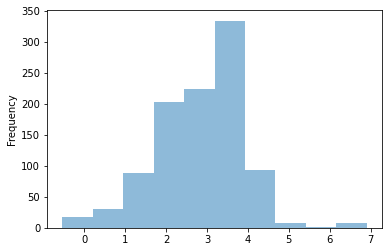

In [ ]:
#@title Aquifer depth avg (total depht of the aquifer T4 in m)
# This is the Depth of the Aquifer= Max regolith depth - Depth of soil
aq_depth_average=soilproperties['DER_000_999_EV']-soilproperties['DES_000_200_EV']
# remove outlyers
aq_depth_average[aq_depth_average>1000]=1000
log_Dtot=np.log(aq_depth_average)
# print
print(np.mean(aq_depth_average),np.std(aq_depth_average),np.max(aq_depth_average),np.min(aq_depth_average))
plt.figure()

log_Dtot.plot.hist(alpha=0.5)

### *4.3 Save inputs as CSV*

In [ ]:
parameters=pd.DataFrame()

parameters['aquifer_length']=L
parameters['areasqm']=areas

parameters['T1_depth_avg']=T1_depth_avg

parameters['T1_WCsat_max']=T1_WCsat_max

parameters['T3_k_avg']=T3_k_avg

parameters['T4_log_k_avg']=soilproperties['b1']

parameters['T4_aquifer_depth']=aq_depth_average

parameters['basin_ID']=np.arange(0,len(parameters.index))+1



# Save
parameters.to_csv(input_folder+'parameters.csv')


In [ ]:
# Generate Initial conditions file as half of the size of each bucket
ini_cond=pd.DataFrame()
ini_cond['basin_ID']=parameters['basin_ID']
# S1 top soil initial value
ini_cond['T1_0']=T1_depth_avg*1000/2
# T2 surface runoff 
ini_cond['T2_0']=0

# T3 Subsoil
ini_cond['T3_0']=700/2
#T4
ini_cond['T4_0']=aq_depth_average*1000/2
# Save
ini_cond.to_csv(input_folder+'Ini_cond.csv')


### *4.4 Visualization of inputs (optional)*

In [ ]:
# New map vizualization with geemap
center_aus=[-29,133.95]
Map1 = emap.Map(center=center_aus, zoom_start=5)

In [ ]:
# Palletes
glc30Palette = [
  'ff02d0', # 1-Cultaved Lands
  '147749', # 2-Forest    
  'a9d05f', # 3-Grassland  
  '3eb370', # 4-Shrublands
  '7ecef4', # 5-Wetlands
  '00569a', # 6-Water bodies          
  '6f6f6f',  # 7-Tundra
  '911818', # 8-Artificial Surfaces
  'cacaca', # 9-Bareland    
  'f9f3c1', # 10-Permanent snow and ice  
]
SavanaPallete=['312018', '9c9792', '98736a', 'f4cc8f', 'fdebc0']
ElevationPallete=['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
rainbow= [
    '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
  ]

In [ ]:
#Add Elevation
DEMvis= {
  'min': 0,
  'max': 1300,
  'palette': glc30Palette}
Map1.addLayer(DEM, DEMvis, 'DEM')

In [ ]:
#Add Soil Depth
SLGA=ee.ImageCollection("CSIRO/SLGA")
soilDepth = ee.Image(SLGA.filter(ee.Filter.eq('attribute_code', 'DES')).select('DES_000_200_EV').first())# this one is just for visualization
# Use folium to visualize the imagery.
soilDepthVis = {'pallete': glc30Palette, 'min': 0.1, 'max': 1.84}

Map1.addLayer(soilDepth, soilDepthVis, 'Soil Depth')

In [ ]:
# Add porosity
porosity=ee.Image('users/rescobarcorrea/Porosity_aus') # Aquifer porosity - band B1-1
porosityVis = {'pallete': rainbow, 'min': 0, 'max': 1}

Map1.addLayer(porosity, porosityVis, 'Porosity')

In [ ]:
#Add SGDbasins 
Map1.addLayer(SGDbasins, {'color': '#ff6a00', 'strokeWidth': 1}, 'SGDbasins')


In [ ]:
# Show map
Map1.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map1

## 5. Get transient inputs: Precipitation (mm/d) and EVT (kg/m2/8days) (requires tu run 1, 2 and 3)


In [ ]:
# Import the selected coastal cathments from Hydrosheds Basins Lv. 12.
SGDbasins = ee.FeatureCollection('users/rescobarcorrea/CoCatch_aus')
resolution=500 # resolution in meters

start_date= ('2010-01-01')# minimum 2007-01-01
#end_date= (datetime.today().strftime('%Y-%m-%d')) # today - a month
#end_date= (datetime.today()-timedelta(days=30)).strftime('%Y-%m-%d')
end_date= ('2018-12-31')# minimum 2007-01-01
#print(datetime.today().strftime('%Y-%m-%d'))
daterange = pd.date_range(start_date, end_date)
print(len(daterange))

3287


In [ ]:
#method 2 - In this method I have to get the stats per every Precip, then add it to a Pd.DF with date as name takes about 96sec/month or 20min/year
# evry time this code is run, It will add new values to the table
start_time = datetime.now()
print('----------Start time----------',start_time)

P=pd.DataFrame()
ET=pd.DataFrame()

#evt = pd.DataFrame()
for single_date in daterange:
    chirps1 = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterDate(single_date)
    chirps2=ee.Image(chirps1.first())

    sd= (parse(single_date.strftime('%Y-%m-%d'))-timedelta(days=4)).strftime('%Y-%m-%d') #error correact here strt aand end date
    ed= (parse(single_date.strftime('%Y-%m-%d'))+timedelta(days=4)).strftime('%Y-%m-%d')
    modis = ee.ImageCollection('MODIS/006/MOD16A2').filterDate(sd,ed).select('PET') # ET is real ET and PET is potential ET
    et2= modis.reduce(ee.Reducer.mean())
    composite=ee.Image.cat(chirps2,et2)
    # Extract mean value of soil properties for each SGD basin
    dist_stats = composite.reduceRegions(SGDbasins, 'mean', resolution)
    print(single_date.strftime('%Y-%m-%d'))
    dist_stats = dist_stats.select(['PET_mean','precipitation'],['PET','P'],retainGeometry=False).getInfo()
    #dist_stats=dist_stats.getInfo()
    dtstats_df = pd.DataFrame()
   
    for dist in dist_stats['features']:
        df = pd.DataFrame([dist['properties']], columns=dist['properties'].keys())
        dtstats_df = pd.concat([dtstats_df, df], axis=0)
          
    print('-')   
    #dtstats_df.column=single_date.strftime('%Y-%m-%d')
    ET = pd.concat([ET, dtstats_df['PET']], axis=1)
    P = pd.concat([P, dtstats_df['P']], axis=1)
# show dF
#print("--- %s seconds ---" % (time.time() - start_time))
print('---------done--------',datetime.now(), 'time passed:',str(datetime.now()-start_time))
print('.')

#COME BACK TO THIS, TRY TO TRANSPOSE FROM THE BEGINING?
P=P.transpose()
P.columns=pd.Series(np.arange(1,len(P.columns)+1))
P['Date']=daterange.strftime('%Y-%m-%d')
#P.set_index('Date')

ET=ET.transpose()
ET.columns=pd.Series(np.arange(1,len(ET.columns)+1))
ET['Date']=daterange.strftime('%Y-%m-%d')
#ET.set_index('Date')

# P.columns=daterange.strftime('%Y-%m-%d')
# ET.columns=daterange.strftime('%Y-%m-%d')


try:
          P1=pd.read_csv(input_folder+'P.csv')
          P1=P1.iloc[:,1:]
          
          ET1=pd.read_csv(input_folder+'ETP.csv')
          ET1=ET1.iloc[:,1:]

          # P1.reset_index(drop=True, inplace=True)
          # ET1.reset_index(drop=True, inplace=True)
          # P.reset_index(drop=True, inplace=True)
          # ET.reset_index(drop=True, inplace=True)
          P.columns=P1.columns
          ET.columns=ET1.columns
          P = pd.concat([P1, P], axis=0)
          ET = pd.concat([ET1, ET], axis=0)
          P.to_csv(input_folder+'P.csv')
          ET.to_csv(input_folder+'ETP.csv')
except:
          P.to_csv(input_folder+'P.csv')
          ET.to_csv(input_folder+'ETP.csv')
#P.to_csv(input_folder+'P.csv')
#ET.to_csv(input_folder+'ET.csv')

# #files.download(pe)
# P

Se han truncado las últimas 5000 líneas del flujo de salida.
-
2012-02-28
-
2012-02-29
-
2012-03-01
-
2012-03-02
-
2012-03-03
-
2012-03-04
-
2012-03-05
-
2012-03-06
-
2012-03-07
-
2012-03-08
-
2012-03-09
-
2012-03-10
-
2012-03-11
-
2012-03-12
-
2012-03-13
-
2012-03-14
-
2012-03-15
-
2012-03-16
-
2012-03-17
-
2012-03-18
-
2012-03-19
-
2012-03-20
-
2012-03-21
-
2012-03-22
-
2012-03-23
-
2012-03-24
-
2012-03-25
-
2012-03-26
-
2012-03-27
-
2012-03-28
-
2012-03-29
-
2012-03-30
-
2012-03-31
-
2012-04-01
-
2012-04-02
-
2012-04-03
-
2012-04-04
-
2012-04-05
-
2012-04-06
-
2012-04-07
-
2012-04-08
-
2012-04-09
-
2012-04-10
-
2012-04-11
-
2012-04-12
-
2012-04-13
-
2012-04-14
-
2012-04-15
-
2012-04-16
-
2012-04-17
-
2012-04-18
-
2012-04-19
-
2012-04-20
-
2012-04-21
-
2012-04-22
-
2012-04-23
-
2012-04-24
-
2012-04-25
-
2012-04-26
-
2012-04-27
-
2012-04-28
-
2012-04-29
-
2012-04-30
-
2012-05-01
-
2012-05-02
-
2012-05-03
-
2012-05-04
-
2012-05-05
-
2012-05-06
-
2012-05-07
-
2012-05-08
-
2012-05-09
-
2

### *5.3 Visulize transient inputs*

I can make here an animated visualization of P and EVT

## 6. TETIS LU3 model


In [ ]:
import numpy as np
import pdb
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Read files if they are not loaded already
input_folder ="/content/drive/My Drive/FSGD-aus/model_input/"
output_folder= "/content/drive/My Drive/FSGD-aus/model_output/"

In [ ]:

parameters  =pd.read_csv(input_folder+"parameters.csv")                                       
ini_cond     =pd.read_csv(input_folder+"Ini_cond.csv") 


In [ ]:
ET          =pd.read_csv(input_folder+"ETP.csv")             
P           =pd.read_csv(input_folder+"P.csv")        

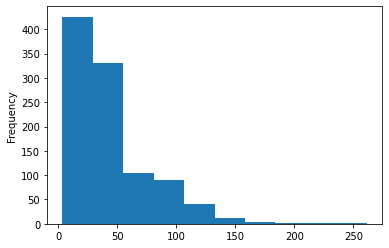

In [ ]:
# parameters all at once
parameters['Hu']=parameters['T1_depth_avg']*parameters['T1_WCsat_max']*1000
parameters["TRs"]=parameters['T1_depth_avg']*1000/parameters['T3_k_avg']
parameters["TRp"]=parameters['aquifer_length']*1000/((10**(parameters['T4_log_k_avg']))*1000*86400) 
parameters["Kp"]=((10**(parameters['T4_log_k_avg']))*1000) 
parameters["Ks"]=parameters['T3_k_avg']
parameters['TRs'].plot.hist()

In [ ]:
#FSGD=pd.DataFrame()
fsgd_pd=pd.DataFrame()
runoff_pd=pd.DataFrame()
percentFSGD=[]
SGDrate=[]
for index,basin in parameters.iterrows():
  # Parameters
  id=int(basin['basin_ID'])-1
  print(id)
  #Catchment area (m2)
  #Area de la cuenca #need to estimate the basin area and change names of variables
  areac=basin['areasqm']
  #Aquifer Lenght in m
  L=basin['aquifer_length']
  #!--------------------------------------------------------
  #Calibration parameters
  #[Tanque 1] Almacenamiento Capilar Hu(mm) (suggested 20-600) 
  # or maximum static storage water content (mm)
  Hu=basin['T1_depth_avg']*basin['T1_WCsat_max']*1000
  #[Tanque 3] Conductividad Sub-Superficial (suggested 1-100) (mm/d) comes from pedotransfer functions
  Ks=basin['T3_k_avg']
  #[Tanque 4] Conductividad Subterraneo (mm/d) (suggested 0.01-10) ccomes from Log K
  Kp=((10**(basin['T4_log_k_avg']))*1000) 
  #Perdidas (mm/d)
  losses=0
  #[Tanque 2] Tiempo residencia flujo superficial (days) (suggested 1-10) we don't really need it..
  TRt=1
  #[Tanque 3] Tiempo residencia flujo sub-superficial (days) (suggested 1-10) or just divide Ks by subsoilheight
  TRs=basin['T1_depth_avg']*1000/Ks
  #TRs=L*10/Ks # jsut multylied by 10 intead of 1000
  #TRs=L*1000/Ks
  #[Tanque 4] Tiempo residencia flujo base (days) (sugested 50-2000) or just divide Kp by L
  #TRp=L*1000/Kp
  TRp=basin['T4_aquifer_depth']*1000/Kp
  #Other parameters
  #Correction factor alfa or infiltration parameter(valores entre: 1-3)
  alfa=2
  #Corretion factor beta or EVT exponent(Valores entre: 0-1)
  beta=0.5
  #--------------------------------------------------------
  #Initial conditions careful with conceptaulization of tanks
  #[Tanque 1] (mm) (suggested 0-100) S1
  H1=ini_cond.loc[id,'T1_0']
  #[Tanque 2] (mm)  (suggested 0-10) assumed small because we selected cathments without 

  H2=ini_cond.loc[id,'T2_0']
  #H2=1
  #[Tanque 3] (mm)  (suggested 0-30) S2
  H3=ini_cond.loc[id,'T3_0']
  #[Tanque 4] (mm) (suggested 0- 2000) S3
  H4=ini_cond.loc[id,'T4_0']

  #Each interval
  FSGD=[]
  Qsim=[]
  percent=[]
  rate=[]
  for day in range(0,len(P)):
    
    #_________________________________________________________
    #2.Entrada del intervalo
    D1=min((P.iloc[day,id+1]*(1-(H1/Hu)**alfa)),Hu-H1)
    D2=max(0,(P.iloc[day,id+1]-D1-Ks))
    D3=max(0,(P.iloc[day,id+1]-D1-D2-Kp))
    D4=max(0,(P.iloc[day,id+1]-D1-D2-D3-losses))
    #_________________________________________________________
    #3.Estado intermedio del intervalo
    H1=D1+H1
    H2=D2+H2
    H3=D3+H3
    H4=D4+H4
    #_________________________________________________________
    #!4.Salidas del intervalo
    EVP=ET.iloc[day,id+1]/8
    Y1= min((EVP*(H1/Hu)**beta),H1)#EVT
    Y2=H2/TRt #Surface runoff original
    #Y2=0 # surface runoff
    Y3=H3/TRs #Subsurface runoff
    Y4=H4/TRp #GW runoff
    #_________________________________________________________
    #5.Estado final del intervalo
    H1=H1-Y1
    H2=H2-Y2
    H3=H3-Y3
    H4=H4-Y4
    #_________________________________________________________
    # 6.Surface discharge (m³/s)
    Qsim.append((Y2+Y3+Y4)*areac/(1000*86400))
    # 7. SGD
    FSGD.append((Y4+Y3)*areac/(1000*86400))
    percent.append((Y3+Y4)*100/(Y2+Y3+Y4))
    rate.append(Y4/10)
    #pdb.set_trace()

  print('FSGD (m³/s) - ' + str(id+1) + ' = ' + str(np.mean(FSGD)))
  print('Percent: ' + str(np.mean(percent)))
  #plt.figure()
  fsgd_pd[str(id+1)]=FSGD
  runoff_pd[str(id+1)]=Qsim
  percentFSGD.append(np.mean(percent))
  SGDrate.append(np.mean(rate)) # in m3/d
avg_SGD=np.mean(fsgd_pd)
totP=np.sum(P)
totETP=np.sum(ET)  


0
FSGD (m³/s) - 1 = 0.164612337958533
Percent: 99.98824129845178
1
FSGD (m³/s) - 2 = 0.02547647134435663
Percent: 99.97414885683179
2
FSGD (m³/s) - 3 = 0.03527914209429714
Percent: 99.97762465038511
3
FSGD (m³/s) - 4 = 1.702837020651721
Percent: 99.99229553160119
4
FSGD (m³/s) - 5 = 0.03781640089377516
Percent: 99.99799500456622
5
FSGD (m³/s) - 6 = 1.5159936271036842
Percent: 99.98582923080664
6
FSGD (m³/s) - 7 = 0.8532188944809465
Percent: 99.99423601338817
7
FSGD (m³/s) - 8 = 1.4420163176138896
Percent: 99.99740245393673
8
FSGD (m³/s) - 9 = 0.031221725147062698
Percent: 99.95361645603725
9
FSGD (m³/s) - 10 = 1.9384986650464224
Percent: 99.97924773356141
10
FSGD (m³/s) - 11 = 0.26708634546128757
Percent: 99.9956866339148
11
FSGD (m³/s) - 12 = 0.5023834410364046
Percent: 99.9804340399531
12
FSGD (m³/s) - 13 = 0.2682456435151812
Percent: 99.99606660483644
13
FSGD (m³/s) - 14 = 0.21957665296490328
Percent: 99.9976118870423
14
FSGD (m³/s) - 15 = 0.3074569676868541
Percent: 99.732101509078

In [ ]:
#save results as CVS
fsgd_pd.to_csv(output_folder+'FSGD.csv')

### 6.1 Visualize results as plots


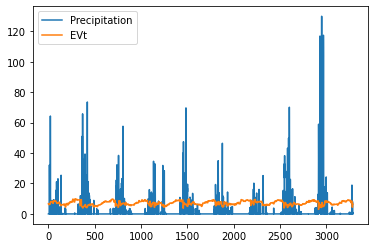

In [ ]:
bas=pd.DataFrame()
id='275'
plt.figure

#bas['Runoff']=runoff_pd[id]
#bas['Fsgd']=fsgd_pd[id]
bas['Precipitation']=P[id]
bas['EVt']=ET[id]/80
#bas.plot.line(logy=True)
bas.plot.line()


<Figure size 432x288 with 0 Axes>

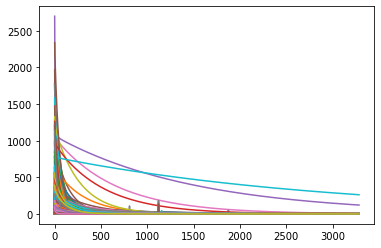

In [ ]:
plt.figure()
runoff_pd.plot.line(legend=False)

<Figure size 432x288 with 0 Axes>

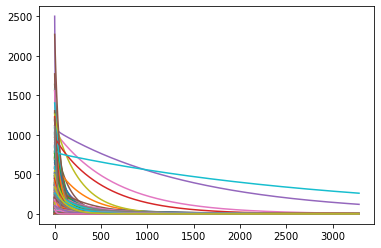

In [ ]:

plt.figure()
fsgd_pd.plot.line(legend=False)


###6.2 Visualize results as map

In [ ]:
# New map vizualization with geemap Vizualization of SGD fluxes in m3/s
center_aus=[-29,133.95]
Map1 = emap.Map(center=center_aus, zoom_start=5)
# Palletes
glc30Palette = [
  'ff02d0', # 1-Cultaved Lands
  '147749', # 2-Forest    
  'a9d05f', # 3-Grassland  
  '3eb370', # 4-Shrublands
  '7ecef4', # 5-Wetlands
  '00569a', # 6-Water bodies          
  '6f6f6f',  # 7-Tundra
  '911818', # 8-Artificial Surfaces
  'cacaca', # 9-Bareland    
  'f9f3c1', # 10-Permanent snow and ice  
]
SavanaPallete=['312018', '9c9792', '98736a', 'f4cc8f', 'fdebc0']
ElevationPallete=['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
rainbow= [
    '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
  ]
flowerpallet1=['#5b9aa0','#eeac99','#e06377','#c83349']
# Add porosity
LogK=ee.Image('users/rescobarcorrea/LogK_aus')# Log of superficial aquifer Permehability - band B1
LogKVis = {'pallete': ElevationPallete, 'min': -15, 'max': 1}

Map1.addLayer(LogK, LogKVis, 'logK')
#Add SGDbasins 
# Import the selected coastal cathments from Hydrosheds Basins Lv. 12.
SGDbasins = ee.FeatureCollection('users/rescobarcorrea/CoCatch_aus')
Map1.addLayer(SGDbasins, {'color': '#ff6a00', 'strokeWidth': 1}, 'SGDbasins')
# Get the centroids of each basin# This function creates a new feature from the centroid of the geometry.
def getCentroid(feature):
  keepProperties = ['id', 'PFAF_ID']  # Keep this list of properties.
  centroid = feature.geometry().centroid()# Get the centroid of the feature's geometry.
  return ee.Feature(centroid).copyProperties(feature, keepProperties)# Return a new Feature, copying properties from the old Feature.
centroids = SGDbasins.map(getCentroid)# Map the centroid getting function over the features.
#Plot centroinds as dots
i=0
for centroid in centroids.getInfo()['features']: # instead of getInfo, try .evaluate
  if avg_SGD[i] <= np.percentile(avg_SGD, 25):
      coloring=flowerpallet1[0]
  elif (avg_SGD[i]>np.percentile(avg_SGD, 50)) & (avg_SGD[i]<=np.percentile(avg_SGD, 75)):
      coloring=flowerpallet1[1]
  elif avg_SGD[i]>np.percentile(avg_SGD, 75):
      coloring=flowerpallet1[2]
  else:
      coloring='crimsom'
  #if avg_SGD[i] <= 200:
 #     avg_SGD[i]=0
  folium.CircleMarker(
      location=[centroid['geometry']['coordinates'][1], centroid['geometry']['coordinates'][0]],
      popup=['BasinID: '+str(i+1)+'  - AvgSGD m3/s = '+str(avg_SGD[i])],
      radius=(avg_SGD[i]*0.5),
      color=coloring,
      fill=True,
      fill_color=coloring
   ).add_to(Map1)
  i+=1
# Show map
Map1.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map1

In [ ]:
# New map vizualization with geemap Vizualization of SGD rate in cm/d
center_aus=[-29,133.95]
Map1 = emap.Map(center=center_aus, zoom_start=5)
# Palletes
glc30Palette = [
  'ff02d0', # 1-Cultaved Lands
  '147749', # 2-Forest    
  'a9d05f', # 3-Grassland  
  '3eb370', # 4-Shrublands
  '7ecef4', # 5-Wetlands
  '00569a', # 6-Water bodies          
  '6f6f6f',  # 7-Tundra
  '911818', # 8-Artificial Surfaces
  'cacaca', # 9-Bareland    
  'f9f3c1', # 10-Permanent snow and ice  
]
SavanaPallete=['312018', '9c9792', '98736a', 'f4cc8f', 'fdebc0']
ElevationPallete=['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
rainbow= [
    '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
  ]
# Add porosity
LogK=ee.Image('users/rescobarcorrea/LogK_aus')# Log of superficial aquifer Permehability - band B1
LogKVis = {'pallete': ElevationPallete, 'min': -15, 'max': 1}

Map1.addLayer(LogK, LogKVis, 'logK')
#Add SGDbasins 
# Import the selected coastal cathments from Hydrosheds Basins Lv. 12.
SGDbasins = ee.FeatureCollection('users/rescobarcorrea/CoCatch_aus')
Map1.addLayer(SGDbasins, {'color': '#ff6a00', 'strokeWidth': 1}, 'SGDbasins')
# Get the centroids of each basin# This function creates a new feature from the centroid of the geometry.
def getCentroid(feature):
  keepProperties = ['id', 'PFAF_ID']  # Keep this list of properties.
  centroid = feature.geometry().centroid()# Get the centroid of the feature's geometry.
  return ee.Feature(centroid).copyProperties(feature, keepProperties)# Return a new Feature, copying properties from the old Feature.
centroids = SGDbasins.map(getCentroid)# Map the centroid getting function over the features.
#Plot centroinds as dots
i=0
for centroid in centroids.getInfo()['features']: # instead of getInfo, try .evaluate
  folium.CircleMarker(
      location=[centroid['geometry']['coordinates'][1], centroid['geometry']['coordinates'][0]],
      popup=['BasinID: '+str(i+1)+'  - AvgSGD cm/d = '+str(SGDrate[i])],
      radius=(SGDrate[i]*10),
      color='green',
      fill=True,
      fill_color='green'
   ).add_to(Map1)
  i+=1
# Show map
Map1.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map1

##7. FUTURE work: Calibration

> create long term water balance, refine and verify the use of the TETIS LU3 model







## *Created by:*

**Rogger E Correa**

Research Assitant - Southern Cross University, Australia

Remote Sensing Analyst - Forestry Corporation of New South Wales, Australia

Hydrogeologist - Corporacion Merceditas, Colombia

email: rescobarcorrea@gmail.com

---

2020

## *With the help of:*

**Professor Isaac R. Santos**

Souther Cross University, Australia

University of Gotemburg, Swedeen

**Professor Nils Mossdorf**

Leibniz Centre for Tropical Marine Research (ZMT), Germany

Kiel University, Germany

**Caroline Schneider**

Remote Sensing Analyst - Forestry Corporation of New South Wales, Australia

**Dr. Nicolas Velasquez Giron**

Hydrology research - University of Iowa




---

*I used multiple lines of code from the Colab community, Thanks for sharing*

---

